In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('train.csv')

data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


# Обработка вещественных признаков

In [3]:
import numpy as np
data = data.assign(log_price_doc=np.log1p(data['price_doc']))

In [4]:
data = data.drop(['price_doc'], axis = 1)

In [5]:
numeric_columns = data.loc[:,data.dtypes!=object].columns
numeric_columns

Index(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'log_price_doc'],
      dtype='object', length=276)

In [6]:
for numeric_column in numeric_columns:
    data[numeric_column] = data[numeric_column].fillna(data[numeric_column].mean())

In [7]:
data.isna().sum()

id                    0
timestamp             0
full_sq               0
life_sq               0
floor                 0
                     ..
mosque_count_5000     0
leisure_count_5000    0
sport_count_5000      0
market_count_5000     0
log_price_doc         0
Length: 292, dtype: int64

In [8]:
data[numeric_columns].corr().unstack()

id             id                    1.000000
               full_sq               0.021447
               life_sq               0.012953
               floor                -0.022441
               max_floor             0.004010
                                       ...   
log_price_doc  mosque_count_5000     0.130745
               leisure_count_5000    0.134175
               sport_count_5000      0.223386
               market_count_5000     0.162569
               log_price_doc         1.000000
Length: 76176, dtype: float64

In [9]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    cols_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    cols_corr = cols_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return cols_corr[0:n]

print('Top Absolute Correlations')
print(get_top_abs_correlations(data[numeric_columns], n=50))

Top Absolute Correlations
railroad_station_walk_km              railroad_station_walk_min                1.000000
public_transport_station_km           public_transport_station_min_walk        1.000000
children_preschool                    0_6_all                                  1.000000
children_school                       7_14_all                                 1.000000
metro_min_walk                        metro_km_walk                            1.000000
raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.999990
young_all                             0_13_all                                 0.999885
young_female                          0_13_female                              0.999871
young_male                            0_13_male                                0.999861
full_all                              female_f                                 0.999850
                                      male_f                                   0.999788
young_

In [10]:
def correlation(dataset, cols, threshold=0.9):
    cols_corr = set()
    corr_matrix = dataset[cols].corr().abs()
    n = corr_matrix.shape[0]
    for i in range(n):
        for j in range(i):
            if (corr_matrix.iloc[i, j]>=threshold) and (corr_matrix.columns[j] not in cols_corr):
                col_name = corr_matrix.columns[j]
                cols_corr.add(col_name)
                if col_name in dataset.columns:
                    columns_to_drop.append(col_name)
                    del dataset[col_name]

columns_to_drop = []
correlation(data, numeric_columns, 0.9)

In [11]:
numeric_columns = data.loc[:,data.dtypes!=object].columns
numeric_columns

Index(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'market_count_3000', 'green_part_5000', 'prom_part_5000',
       'trc_sqm_5000', 'cafe_avg_price_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000',
       'log_price_doc'],
      dtype='object', length=126)

In [12]:
from sklearn.feature_selection import VarianceThreshold

cutter = VarianceThreshold(threshold = 0.1)
cutter.fit(data[numeric_columns])
constant_columns = [x for x in data[numeric_columns] if x not in cutter.get_feature_names_out()]

data[constant_columns]

,green_zone_part,indust_part,green_zone_km,cafe_count_500_price_high,mosque_count_500,mosque_count_1000,mosque_count_1500,mosque_count_2000
0,0.189727,0.000070,0.600973,0,0,0,0,0
1,0.372602,0.049637,0.065321,0,0,0,0,0
2,0.112560,0.118537,0.453172,0,0,0,0,0
3,0.194703,0.069753,0.106125,0,0,0,0,0
4,0.015234,0.037316,0.236214,0,0,0,0,0
...,...,...,...,...,...,...,...,...
30466,0.096270,0.300323,0.139814,0,0,0,0,1
30467,0.065444,0.000078,0.271861,0,0,0,0,0
30468,0.496315,0.007122,0.427248,0,0,0,0,0
30469,0.167526,0.093443,0.227547,0,0,0,0,0


# Обработка категориальных признаков

In [13]:
categorical_columns = data.loc[:, data.dtypes == object].columns
categorical_columns

Index(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [14]:
data.describe(include='object')

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
count,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471
unique,1161,2,146,2,2,2,2,2,2,2,2,2,2,2,2,5
top,2014-12-16,Investment,Poselenie Sosenskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
freq,160,19448,1776,28543,28817,28155,30175,19600,29335,27649,29608,27427,28134,29690,29578,8018


In [15]:
mean_encoding_map_dict = {}
for col in categorical_columns:
    if col!='timestamp':
        if data[col].nunique()<5:
            one_hot = pd.get_dummies(data[col], prefix = col, drop_first = True)
            data = pd.concat((data.drop(col,axis = 1), one_hot), axis = 1)
        else:
            mean_encoding_map = data.groupby(col)['log_price_doc'].mean().to_dict()
            mean_encoding_map_dict[col] = mean_encoding_map
            mean_target = data.groupby(col)['log_price_doc'].mean()
            data[col] = data[col].map(mean_target)

In [16]:
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,False,False,False,False
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,False,False,False,False
2,3,2011-08-27,43,29.0,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,True,False,False,False,False,False,False,False
3,4,2011-09-01,89,50.0,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,False,False,False,False
4,5,2011-09-05,77,77.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,True,True,False,False,False,False,False,True


In [17]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

In [18]:
data = data.sort_values('timestamp')
data

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year
0,1,2011-08-20,43,27.000000,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,False,False,8,2011
1,2,2011-08-23,34,19.000000,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,False,False,8,2011
2,3,2011-08-27,43,29.000000,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,True,False,False,False,False,False,False,False,8,2011
3,4,2011-09-01,89,50.000000,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,False,False,9,2011
4,5,2011-09-05,77,77.000000,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,True,True,False,False,False,False,False,True,9,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30465,30468,2015-06-30,52,34.403271,13.0,17.000000,1.000000,3068.057097,2.000000,1.000000,...,True,True,False,False,True,False,False,False,6,2015
30466,30469,2015-06-30,44,27.000000,7.0,9.000000,1.000000,1975.000000,2.000000,6.000000,...,True,False,False,False,False,False,False,False,6,2015
30467,30470,2015-06-30,86,59.000000,3.0,9.000000,2.000000,1935.000000,4.000000,10.000000,...,True,True,False,False,True,False,False,False,6,2015
30468,30471,2015-06-30,45,34.403271,10.0,20.000000,1.000000,3068.057097,1.000000,1.000000,...,False,False,False,False,False,False,False,False,6,2015


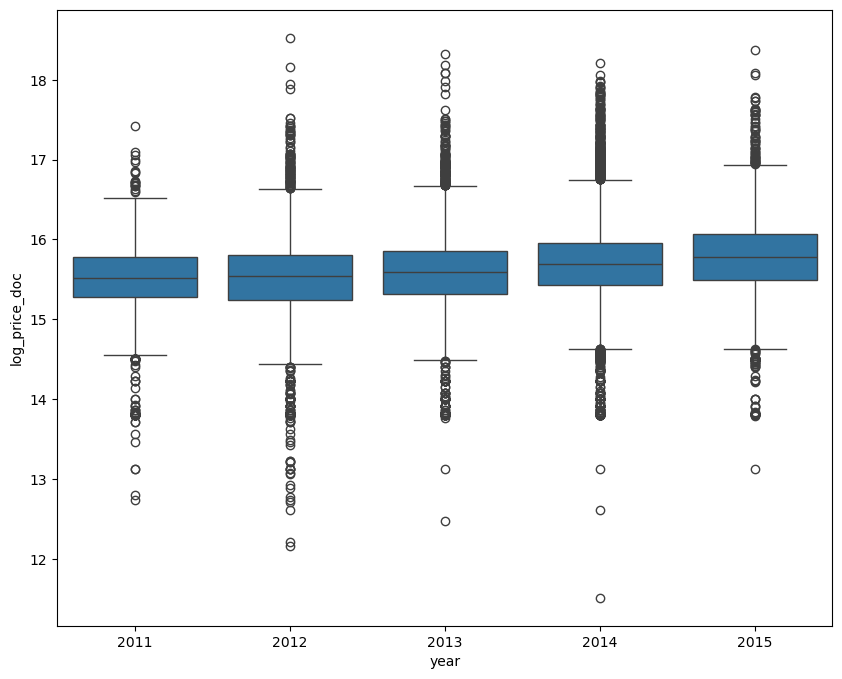

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(10,8)

sns.boxplot(y = 'log_price_doc', x = data['year'].astype('category'), data = data)

plt.show()

In [20]:
one_hot = pd.get_dummies(data['year'], prefix = 'year', drop_first = True)
data = pd.concat((data.drop('year', axis = 1), one_hot), axis = 1)
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year_2012,year_2013,year_2014,year_2015
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,8,False,False,False,False
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,8,False,False,False,False
2,3,2011-08-27,43,29.0,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,8,False,False,False,False
3,4,2011-09-01,89,50.0,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,9,False,False,False,False
4,5,2011-09-05,77,77.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,True,9,False,False,False,False


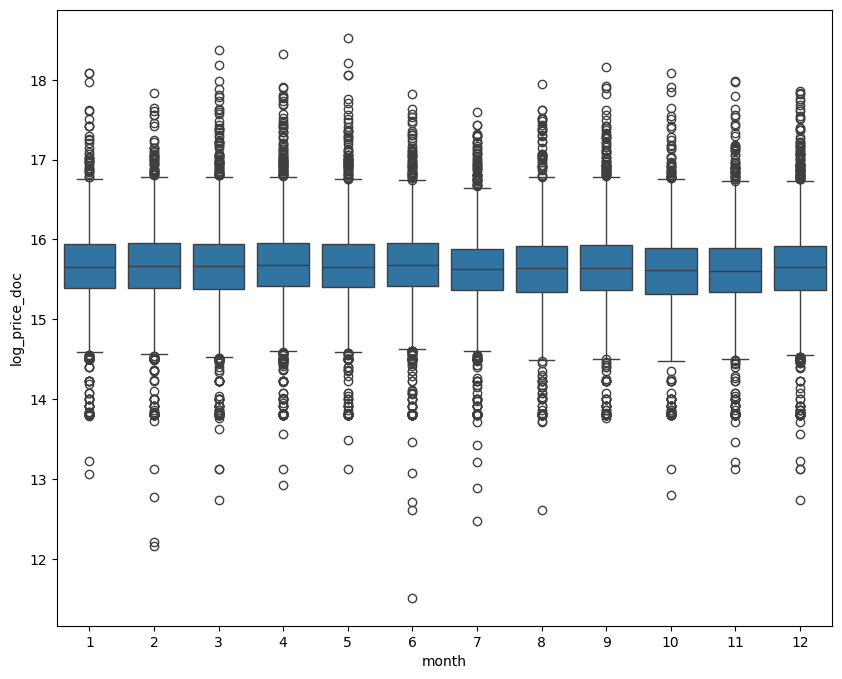

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(10,8)

sns.boxplot(y = 'log_price_doc', x = data['month'].astype('category'), data = data)

plt.show()

In [22]:
one_hot = pd.get_dummies(data['month'], prefix = 'month', drop_first = True)
data = pd.concat((data.drop('month', axis = 1), one_hot), axis = 1)
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,True,False,False,False,False
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,True,False,False,False,False
2,3,2011-08-27,43,29.0,2.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,True,False,False,False,False
3,4,2011-09-01,89,50.0,9.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,True,False,False,False
4,5,2011-09-05,77,77.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,...,False,False,False,False,False,False,True,False,False,False


In [23]:
data = data.drop('timestamp', axis = 1)

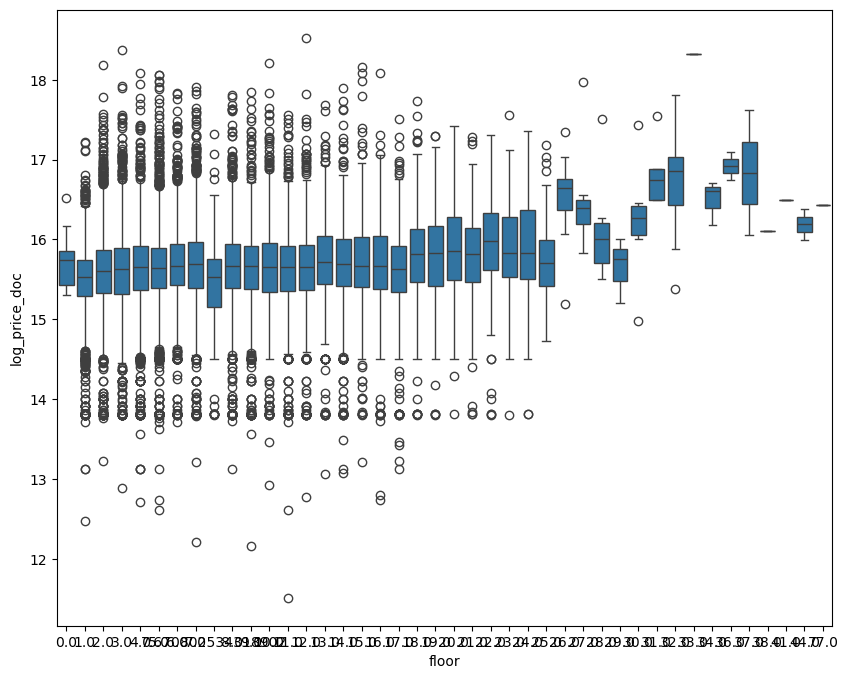

In [24]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.boxplot(y = 'log_price_doc', x = data['floor'].astype('category'), data = data)

plt.show()

In [25]:
data = data*1
data = data.drop(['year_2012','year_2013','year_2014','year_2015','month_6'], axis = 1)

In [26]:
X = data.drop('log_price_doc', axis = 1)
Y = data['log_price_doc']

# Построение модели

In [27]:
from sklearn.model_selection import TimeSeriesSplit
splitter = TimeSeriesSplit(n_splits = 4)

In [28]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

test_losses = []
train_losses = []

for train_index, test_index in splitter.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]

    model = LinearRegression()
    model.fit(X_train, Y_train)

    train_losses.append(np.mean((model.predict(X_train) - Y_train)**2))
    test_losses.append(np.mean((model.predict(X_test) - Y_test)**2))

print(f'MSLE на тренировочной выборке равна {round(np.mean(train_losses),3)}')
print(f'MSLE на тестовой выборке равна {round(np.mean(test_losses),3)}')

MSLE на тренировочной выборке равна 0.282
MSLE на тестовой выборке равна 0.329


In [29]:
from sklearn.model_selection import cross_validate

model = LinearRegression()

cv_result = cross_validate(model, X, Y,
                          scoring = 'neg_mean_squared_error',
                          cv = splitter, return_train_score = True)

cv_result

{'fit_time': array([0.04642558, 0.07711077, 0.10089493, 0.13337946]),
 'score_time': array([0.01064038, 0.01316071, 0.01108742, 0.01191092]),
 'test_score': array([-0.24986911, -0.62463468, -0.24031394, -0.20074924]),
 'train_score': array([-0.32791223, -0.27233635, -0.26829521, -0.25891826])}

In [30]:
print(f'MSLE на тренировочной выборке равна {-round(np.mean(cv_result['train_score']),3)}')
print(f'MSLE на тестовой выборке равна {-round(np.mean(cv_result['test_score']),3)}')

MSLE на тренировочной выборке равна 0.282
MSLE на тестовой выборке равна 0.329


In [31]:
from sklearn.linear_model import Lasso, Ridge
model = Lasso(max_iter = 100000)

cv_result = cross_validate(model, X, Y,
                          scoring = 'neg_mean_squared_error',
                          cv = splitter, return_train_score = True)

print(f'MSLE на тренировочной выборке для Lasso равна {-round(np.mean(cv_result['train_score']),3)}')
print(f'MSLE на тестовой выборке для Lasso равна {-round(np.mean(cv_result['test_score']),3)}')

MSLE на тренировочной выборке для Lasso равна 0.328
MSLE на тестовой выборке для Lasso равна 0.348


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),
                 ('Lasso', Lasso(max_iter = 100000))])

cv_result_pipe = cross_validate(pipe, X, Y,
                               scoring = 'neg_mean_squared_error',
                               cv = splitter, return_train_score = True)
print(f'MSLE на тренировочной выборке для Lasso равна {-round(np.mean(cv_result_pipe['train_score']),3)}')
print(f'MSLE на тестовой выборке для Lasso равна {-round(np.mean(cv_result_pipe['test_score']),3)}')

MSLE на тренировочной выборке для Lasso равна 0.382
MSLE на тестовой выборке для Lasso равна 0.355


In [33]:
alphas = np.linspace(start = 0.001, stop = 1, num = 30)
alphas

array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "Lasso__alpha": alphas
}

# Тюнинг модели, настройка параметров

search = GridSearchCV(pipe, param_grid,
                     cv = splitter, scoring = 'neg_mean_squared_error')

search.fit(X, Y)
print(search.best_params_)

{'Lasso__alpha': np.float64(0.10434482758620689)}


In [35]:
print(f"CV score = {search.best_score_:.5f}")

CV score = -0.30266


In [36]:
pipe.set_params(Lasso__alpha = search.best_params_['Lasso__alpha'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('Lasso',
                 Lasso(alpha=np.float64(0.10434482758620689),
                       max_iter=100000))])

In [37]:
new_cv_result = cross_validate(pipe, X, Y, 
                               scoring = 'neg_mean_squared_error',
                               cv = splitter, return_train_score = True)

print(f'MSLE на тренировочной выборке для Lasso равна {-round(np.mean(new_cv_result['train_score']),3)}')
print(f'MSLE на тестовой выборке для Lasso равна {-round(np.mean(new_cv_result['test_score']),3)}')

MSLE на тренировочной выборке для Lasso равна 0.329
MSLE на тестовой выборке для Lasso равна 0.303


In [38]:
df= pd.concat((X,Y), axis = 1)

In [39]:
top_quantile = df['log_price_doc'].quantile(0.975)
low_quantile = df['log_price_doc'].quantile(0.025)

print(f"Топ 2,5% значений таргета: {top_quantile}")
print(f"Топ 97,5% значений таргета: {low_quantile}")

Топ 2,5% значений таргета: 16.695984159473213
Топ 97,5% значений таргета: 13.815511557963774


In [40]:
df = df[
    (df['log_price_doc']>low_quantile) & (df['log_price_doc']<top_quantile)
]

In [41]:
X_new, Y_new =  df.drop('log_price_doc', axis = 1), df['log_price_doc']

In [42]:
new_splitter = TimeSeriesSplit(n_splits = 4)
grid_params = {
    'Lasso__alpha': alphas
}

search = GridSearchCV(pipe, grid_params,
                     cv = new_splitter, scoring = 'neg_mean_squared_error')

search.fit(X_new, Y_new)

print(search.best_params_)
print(f"CV score = {search.best_score_:.5f}")

{'Lasso__alpha': np.float64(0.06989655172413793)}
CV score = -0.16778


In [43]:
pipe.set_params(Lasso__alpha = search.best_params_['Lasso__alpha'])
cv_result = cross_validate(pipe, X_new, Y_new,
                          scoring = 'neg_mean_squared_error',
                          cv = new_splitter, return_train_score = True)

print(f'MSLE на тренировочной выборке для Lasso равна {-round(np.mean(cv_result['train_score']),3)}')
print(f'MSLE на тестовой выборке для Lasso равна {-round(np.mean(cv_result['test_score']),3)}')

MSLE на тренировочной выборке для Lasso равна 0.167
MSLE на тестовой выборке для Lasso равна 0.168


In [44]:
pipe.fit(X_new, Y_new)
pipe.predict(X_new.head(1).values)

C:\Users\jackt\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([15.63276094])

# Делаем предсказания для test.csv

In [45]:
data = pd.read_csv('test.csv')

data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


# Обработка вещественных признаков

In [46]:
numeric_columns = data.loc[:,data.dtypes!=object].columns
numeric_columns

Index(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000'],
      dtype='object', length=275)

In [47]:
for numeric_column in numeric_columns:
    data[numeric_column] = data[numeric_column].fillna(data[numeric_column].mean())

In [48]:
data.isna().sum()

id                    0
timestamp             0
full_sq               0
life_sq               0
floor                 0
                     ..
church_count_5000     0
mosque_count_5000     0
leisure_count_5000    0
sport_count_5000      0
market_count_5000     0
Length: 291, dtype: int64

In [49]:
data[numeric_columns].corr().unstack()

id                 id                    1.000000
                   full_sq               0.003626
                   life_sq              -0.040347
                   floor                -0.000874
                   max_floor             0.019492
                                           ...   
market_count_5000  church_count_5000     0.519207
                   mosque_count_5000     0.320569
                   leisure_count_5000    0.464283
                   sport_count_5000      0.722918
                   market_count_5000     1.000000
Length: 75625, dtype: float64

In [50]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    cols_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    cols_corr = cols_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return cols_corr[0:n]

print('Top Absolute Correlations')
print(get_top_abs_correlations(data[numeric_columns], n=50))

Top Absolute Correlations
metro_min_walk                        metro_km_walk                            1.000000
public_transport_station_km           public_transport_station_min_walk        1.000000
children_school                       7_14_all                                 1.000000
children_preschool                    0_6_all                                  1.000000
railroad_station_walk_km              railroad_station_walk_min                1.000000
raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.999990
young_all                             0_13_all                                 0.999873
young_male                            0_13_male                                0.999855
young_female                          0_13_female                              0.999849
full_all                              female_f                                 0.999848
                                      male_f                                   0.999787
young_

In [51]:
# дропнуть колонки с корреляцией
'''
def correlation(dataset, cols, threshold=0.9):
    cols_corr = set()
    corr_matrix = dataset[cols].corr().abs()
    n = corr_matrix.shape[0]
    for i in range(n):
        for j in range(i):
            if (corr_matrix.iloc[i, j]>=threshold) and (corr_matrix.columns[j] not in cols_corr):
                col_name = corr_matrix.columns[j]
                cols_corr.add(col_name)
                if col_name in dataset.columns:
                    columns_to_drop.append(col_name)
                    del dataset[col_name]

columns_to_drop = []
correlation(data, numeric_columns, 0.9)
'''
data = data.drop(columns_to_drop, axis = 1)

In [52]:
numeric_columns = data.loc[:,data.dtypes!=object].columns
numeric_columns

Index(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'mosque_count_3000', 'market_count_3000', 'green_part_5000',
       'prom_part_5000', 'trc_sqm_5000', 'cafe_avg_price_5000',
       'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000',
       'market_count_5000'],
      dtype='object', length=125)

In [53]:
from sklearn.feature_selection import VarianceThreshold

cutter = VarianceThreshold(threshold = 0.1)
cutter.fit(data[numeric_columns])
constant_columns = [x for x in data[numeric_columns] if x not in cutter.get_feature_names_out()]

data[constant_columns]

,green_zone_part,indust_part,green_zone_km,cafe_count_500_price_high,mosque_count_500,mosque_count_1000,mosque_count_1500,mosque_count_2000
0,0.137846,0.041116,0.061485,0,0,0,0,1
1,0.496315,0.007122,0.000000,0,0,0,0,0
2,0.065409,0.225825,0.580638,0,0,0,0,0
3,0.262459,0.017647,0.025446,0,0,0,0,0
4,0.496315,0.007122,0.427248,0,0,0,0,0
...,...,...,...,...,...,...,...,...
7657,0.127002,0.135650,0.199909,0,0,0,0,0
7658,0.349935,0.011654,0.991824,0,0,0,0,0
7659,0.065444,0.000078,0.189089,1,0,0,0,1
7660,0.075790,0.100456,0.766444,0,0,0,0,0


# Обработка категориальных признаков

In [54]:
categorical_columns = data.loc[:, data.dtypes == object].columns
categorical_columns

Index(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [55]:
data.describe(include='object')

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
count,7662,7629,7662,7662,7662,7662,7662,7662,7662,7662,7662,7662,7662,7662,7662,7662
unique,274,2,145,2,2,2,2,2,2,2,2,2,2,2,2,5
top,2016-01-25,Investment,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
freq,80,4998,584,6971,7248,7396,7597,4864,7344,7130,7413,6876,7104,7339,7423,2060


In [56]:
#mean_encoding_map_dict = {}
for col in categorical_columns:
    if col!='timestamp':
        if data[col].nunique()<5:
            one_hot = pd.get_dummies(data[col], prefix = col, drop_first = True)
            data = pd.concat((data.drop(col,axis = 1), one_hot), axis = 1)
        else:
            data[col] = data[col].map(mean_encoding_map_dict[col])

In [57]:
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes
0,30474,2015-07-01,39.0,20.700000,2,9,1,1998.0,1,8.9,...,False,False,False,False,False,False,False,False,False,False
1,30475,2015-07-01,79.2,32.660037,8,17,1,0.0,3,1.0,...,False,False,False,False,False,False,False,False,False,False
2,30476,2015-07-01,40.5,25.100000,3,5,2,1960.0,2,4.8,...,False,True,True,False,False,False,False,False,False,False
3,30477,2015-07-01,62.8,36.000000,17,17,1,2016.0,2,62.8,...,False,False,False,False,False,False,False,False,False,False
4,30478,2015-07-01,40.0,40.000000,17,17,1,0.0,1,1.0,...,False,False,False,False,False,False,False,False,False,False


In [58]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

In [59]:
data = data.sort_values('timestamp')
data

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year
0,30474,2015-07-01,39.00,20.700000,2,9,1,1998.000000,1,8.9,...,False,False,False,False,False,False,False,False,7,2015
14,30488,2015-07-01,69.30,32.660037,7,1,1,1820.888099,2,1.0,...,False,False,False,False,False,False,False,False,7,2015
13,30487,2015-07-01,39.80,18.900000,4,17,1,2013.000000,1,9.9,...,False,False,False,False,False,False,False,False,7,2015
11,30485,2015-07-01,39.20,10.000000,11,17,4,0.000000,1,10.0,...,False,False,False,False,False,False,False,False,7,2015
10,30484,2015-07-01,37.26,32.660037,4,15,4,2017.000000,1,8.0,...,False,False,False,False,False,False,False,False,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,38131,2016-05-26,52.20,31.800000,10,12,5,1973.000000,2,9.1,...,True,False,False,False,False,False,False,False,5,2016
7658,38132,2016-05-28,54.09,32.660037,14,0,1,1820.888099,2,0.0,...,False,False,False,False,False,False,False,False,5,2016
7660,38134,2016-05-30,34.80,19.800000,8,9,5,1977.000000,1,6.4,...,False,False,True,False,False,False,False,False,5,2016
7659,38133,2016-05-30,41.08,1.000000,12,1,1,1.000000,1,1.0,...,True,True,False,False,True,False,False,False,5,2016


In [60]:
one_hot = pd.get_dummies(data['year'], prefix = 'year', drop_first = True)
data = pd.concat((data.drop('year', axis = 1), one_hot), axis = 1)
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year_2016
0,30474,2015-07-01,39.00,20.700000,2,9,1,1998.000000,1,8.9,...,False,False,False,False,False,False,False,False,7,False
14,30488,2015-07-01,69.30,32.660037,7,1,1,1820.888099,2,1.0,...,False,False,False,False,False,False,False,False,7,False
13,30487,2015-07-01,39.80,18.900000,4,17,1,2013.000000,1,9.9,...,False,False,False,False,False,False,False,False,7,False
11,30485,2015-07-01,39.20,10.000000,11,17,4,0.000000,1,10.0,...,False,False,False,False,False,False,False,False,7,False
10,30484,2015-07-01,37.26,32.660037,4,15,4,2017.000000,1,8.0,...,False,False,False,False,False,False,False,False,7,False


In [61]:
one_hot = pd.get_dummies(data['month'], prefix = 'month', drop_first = True)
data = pd.concat((data.drop('month', axis = 1), one_hot), axis = 1)
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,month_2,month_3,month_4,month_5,month_7,month_8,month_9,month_10,month_11,month_12
0,30474,2015-07-01,39.00,20.700000,2,9,1,1998.000000,1,8.9,...,False,False,False,False,True,False,False,False,False,False
14,30488,2015-07-01,69.30,32.660037,7,1,1,1820.888099,2,1.0,...,False,False,False,False,True,False,False,False,False,False
13,30487,2015-07-01,39.80,18.900000,4,17,1,2013.000000,1,9.9,...,False,False,False,False,True,False,False,False,False,False
11,30485,2015-07-01,39.20,10.000000,11,17,4,0.000000,1,10.0,...,False,False,False,False,True,False,False,False,False,False
10,30484,2015-07-01,37.26,32.660037,4,15,4,2017.000000,1,8.0,...,False,False,False,False,True,False,False,False,False,False


In [62]:
data = data.drop('timestamp', axis = 1)

In [63]:
data = data*1
data = data.drop(['year_2016'], axis = 1)

In [64]:
pipe.predict(data.head(2))

array([15.51011144, 15.30323736])

In [75]:
data = data.sort_values('id')
predictions = pipe.predict(data)

In [80]:
result = pd.DataFrame()
result['id'] = data['id']
result['price_doc'] = np.exp(predictions).round(2)
result.to_csv('my_submission.csv', index = False)

In [81]:
my_submission = pd.read_csv('my_submission.csv')
my_submission

,id,price_doc
0,30474,5444472.53
1,30475,7151261.78
2,30476,5842412.81
3,30477,5798002.86
4,30478,5488576.94
...,...,...
7657,38131,7112811.72
7658,38132,5235710.47
7659,38133,5440154.96
7660,38134,5561441.19


In [65]:
submission_example = pd.read_csv('sample_submission.csv')
submission_example

,id,price_doc
0,30474,7118500.41
1,30475,7118500.41
2,30476,7118500.41
3,30477,7118500.41
4,30478,7118500.41
...,...,...
7657,38131,7118500.41
7658,38132,7118500.41
7659,38133,7118500.41
7660,38134,7118500.41


# Сегментация данных

In [66]:
Owner_Occupier = df[df['product_type_OwnerOccupier'] == 1].copy()
Investment = df[df['product_type_OwnerOccupier'] == 0].copy()

In [67]:
X_owner_occupier = Owner_Occupier.drop('log_price_doc', axis = 1)
Y_owner_occupier = Owner_Occupier['log_price_doc']

X_investment = Investment.drop('log_price_doc', axis = 1)
Y_investment = Investment['log_price_doc']

In [68]:
search_Owner_Occupier = GridSearchCV(pipe, grid_params,
                                    cv = new_splitter, scoring = 'neg_mean_squared_error')

search_Owner_Occupier.fit(X_owner_occupier, Y_owner_occupier)

print(search_Owner_Occupier.best_params_)
print(f"CV score = {search_Owner_Occupier.best_score_:.5f}")

pipe.set_params(Lasso__alpha = search_Owner_Occupier.best_params_['Lasso__alpha'])
cv_result_owner_occupier = cross_validate(pipe, X_owner_occupier, Y_owner_occupier,
                                         scoring = 'neg_mean_squared_error',
                                         cv = new_splitter, return_train_score = True)

error_Occupier_train = -np.mean(cv_result_owner_occupier['train_score'])
error_Occupier_test = -np.mean(cv_result_owner_occupier['test_score'])

print(f"Среднее MSLE на тренировочных фолдах: {error_Occupier_train.round(3)}")
print(f"Среднее MSLE на тестовых фолдах: {error_Occupier_test.round(3)}")

{'Lasso__alpha': np.float64(0.035448275862068966)}
CV score = -0.07829
Среднее MSLE на тренировочных фолдах: 0.067
Среднее MSLE на тестовых фолдах: 0.078


In [69]:
search_Investment = GridSearchCV(pipe, grid_params,
                                    cv = new_splitter, scoring = 'neg_mean_squared_error')

search_Investment.fit(X_investment, Y_investment)

print(search_Investment.best_params_)
print(f"CV score = {search_Investment.best_score_:.5f}")

pipe.set_params(Lasso__alpha = search_Investment.best_params_['Lasso__alpha'])
cv_result_investment = cross_validate(pipe, X_investment, Y_investment,
                                         scoring = 'neg_mean_squared_error',
                                         cv = new_splitter, return_train_score = True)

error_Investment_train = -np.mean(cv_result_investment['train_score'])
error_Investment_test = -np.mean(cv_result_investment['test_score'])

print(f"Среднее MSLE на тренировочных фолдах: {error_Investment_train.round(3)}")
print(f"Среднее MSLE на тестовых фолдах: {error_Investment_test.round(3)}")

{'Lasso__alpha': np.float64(0.001)}
CV score = -0.17536
Среднее MSLE на тренировочных фолдах: 0.176
Среднее MSLE на тестовых фолдах: 0.175


In [70]:
print(pipe.predict(X_investment.head(1)), Y_investment.head(1))

[15.63276094] 0    15.581952
Name: log_price_doc, dtype: float64


In [71]:
n_Occupier = Owner_Occupier.shape[0]
n_Investment = Investment.shape[0]

# считаем долю данных относительно общей выборки

share_Occupier = n_Occupier / df.shape[0]
share_Investment = n_Investment / df.shape[0]

weighted_error_train = share_Occupier * error_Occupier_train + share_Investment * error_Investment_train
weighted_error_test = share_Occupier * error_Occupier_test + share_Investment * error_Investment_test

print(f"Среднее взвешенное MSLE на тренировочных фолдах: {weighted_error_train.round(3)}")
print(f"Среднее взвешенное MSLE на тестовых фолдах: {weighted_error_test.round(3)}")

Среднее взвешенное MSLE на тренировочных фолдах: 0.135
Среднее взвешенное MSLE на тестовых фолдах: 0.139
